# Recreating Fig. 2

The paper [NOISE OR SIGNAL: THE ROLE OF IMAGE BACKGROUNDS IN OBJECT RECOGNITION](https://openreview.net/pdf?id=gl3D-xY7wLq) explores the effect of background on predictive deep learning models.


![title](Capture.png)

In this paper they show the following accuracies can be achieved on their models when training them on modified data then testing them on the original data. 

Our goal is to recreate these results

# 1. Setting up the data

In [1]:
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from collections import Counter
import torchvision.models as models

In [2]:
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor()])
train = datasets.ImageFolder('data/no_fg/train', transform=transform)
test = datasets.ImageFolder('data/no_fg/val', transform=transform)

In [3]:
names = ["dog", "bird", "wheeled_vehicle", "reptile", "carnivore", "insect", "musical_instrument", "primate", "fish"]

In [5]:
dic = {}
for i in range(len(names)):
    dic[i] = names[i]
c = dict(Counter(train.targets))



In [6]:
for i in range(len(c)):
    c[dic[i]] = c.pop(i)

In [7]:
c

{'dog': 5045,
 'bird': 5045,
 'wheeled_vehicle': 5045,
 'reptile': 5045,
 'carnivore': 5045,
 'insect': 5045,
 'musical_instrument': 5045,
 'primate': 5045,
 'fish': 5045}

In [12]:
dataloaders = {"train" : torch.utils.data.DataLoader(train, batch_size=32, shuffle=True),
               "test" :  torch.utils.data.DataLoader(test,  batch_size=32, shuffle=True) } 

(224, 224, 3)
primate


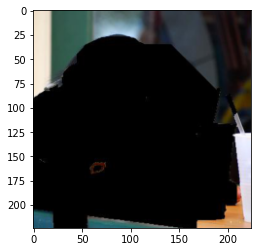

In [13]:
images, labels = next(iter(dataloaders["train"]))
im = np.asarray(images[0])
im = np.moveaxis(im, 0, -1)
print(im.shape)
print(dic[int(labels[0])])
plt.imshow(im)

# 2. Importing premade model

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [30]:
resnet50 = models.resnet50(pretrained = True).to(device)

In [31]:
for param in resnet50.parameters():
    param.requires_grad = False

In [32]:
resnet50.fc

Linear(in_features=2048, out_features=1000, bias=True)

In [33]:
resnet50.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 9)).to(device)

In [34]:
criterion = nn.CrossEntropyLoss()

In [35]:
optimizer = optim.Adam(resnet50.fc.parameters())

## 3. Training

In [36]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [37]:
model_trained = train_model(resnet50, criterion, optimizer, num_epochs=3)

Epoch 1/3
----------


KeyboardInterrupt: 